In [45]:
import torch
from models import simplecnn
from dataset import get_spurious_samples, make_dataloaders
from easydict import EasyDict  as edict
from torchvision.transforms import ToTensor, Normalize, Compose
from collections import defaultdict
from train import get_gradients_from_data
from copy import deepcopy


def mean_accuracy(logits, y):
    preds = (logits.squeeze() > 0.).float()
    return  ((preds - y).abs() < 1e-2).float().mean()

task_args = edict()
args = edict()
args.output_dims = 1
args.eval_datasets = dict()
task_args.mode = ["task"
                   #, 'play'
                  # ,'forget'
                   ]
args.dataset_paths = {'synmnist': "SynMNIST",
                       "camelyon": "../datasets",
                       "mnistcifar": "../datasets/MNISTCIFAR"}
task_args.dataset = {'name': 'mnistcifar', 'corr': 0.0, 'splits': ['train','val','test'], 'bs': 10000}
args.model='scnn'
for k,v in task_args.items():
    args['task_'+k] = v
    
args.task_args = task_args

dls = make_dataloaders(args)

x = defaultdict(list)
y = defaultdict(list)

for split in ['train', 'val']:
    for xs,ys  in dls['task'][split]:
        x[split].append(xs)
        y[split].append(ys)
        
    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])


# Cargar modelo preentrenado
ruta = "models/scnn_mnistcifar_0.75_222_best_.pth"
weights = torch.load(ruta)
old_weights = weights
model = simplecnn(args)
model.load_state_dict(weights['model'])
model = model

# Registrar hook para obtener valores intermedios
def hook_fn(module, input, output):
    model.output = output

#print(dir(model))
model.features.flatten.register_forward_hook(hook_fn)
# Crear datos espurios vs datos no espurios

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth


In [46]:
from torch.linalg import matrix_rank, svd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from train import mean_accuracy, calculate_mean_accuracy
# for each model



def get_accuracy_fn(args):
    return mean_accuracy if args.output_dims == 1 else calculate_mean_accuracy

def calculate_result(x, y, splits, model, ruta, iterations,least=True):
    weights = torch.load(ruta)
    old_weights = weights
    split_accs = dict()
    model.load_state_dict(weights['model'])
    acc_fn = get_accuracy_fn(args)
    
    for split in splits:
        logits = model(x[split])
       # if args.output_dims == 1:
       #     y[split] = y[split].unsqueeze(1).float()
        split_accs[split] = acc_fn(logits, y[split])
    
    # calculate representations
    model(x['train'])
    reps_train = model.output.clone().detach()
    model(x['val'])
    reps_val = model.output.clone().detach()
    # Get train eigenvectors
    reps_val -= reps_train.mean(dim=0)
    model(x['test'])
    reps_test = model.output.clone().detach()
    # Get train eigenvectors
    reps_test -= reps_train.mean(dim=0)
    U, S, V = torch.pca_lowrank(reps_train, center=True, q=1000)
    y_test = y['val']

    accs = defaultdict(list)

    for k in tqdm(iterations):
        V_selected = V #V[:,:k] if least else V[:,k:]
        with torch.no_grad():
            p_inv = torch.linalg.pinv(V_selected)                # Calculate pseudoinverse...

            logits_train = torch.matmul(reps_train, V_selected)  # Project to k more important directions
            logits_train[:,k] *= 0.8
            logits_train = torch.matmul(logits_train, p_inv)  # Come back to original space via pseudoinverse
            logits_train += reps_train.mean(dim=0)            # Add back the mean from training data to predict
            logits_train = model.fc(logits_train)             # Pass through classifier for result

            accs['train'].append(acc_fn(logits_train,y['train']))

            logits_val = torch.matmul(reps_val, V_selected)      # Project to k more important directions
            logits_val[:,k] *= 0.8
            logits_val = torch.matmul(logits_val, p_inv)      # Come back to original space via pseudoinverse
            logits_val += reps_train.mean(dim=0)              # Add back the mean from training data to predict
            logits_val = model.fc(logits_val)                 # Pass through classifier for result

            accs['val'].append(acc_fn(logits_val,y['val']))
            
            logits_test = torch.matmul(reps_test, V_selected)      # Project to k more important directions
            logits_test[:,k] *= 0.8
            logits_test = torch.matmul(logits_test, p_inv)      # Come back to original space via pseudoinverse
            logits_test += reps_train.mean(dim=0)              # Add back the mean from training data to predict
            logits_test = model.fc(logits_test)                 # Pass through classifier for result

            accs['test'].append(acc_fn(logits_test,y['test']))
    return accs, split_accs

def modulate_result(x, y, splits, model, ruta, modulations, k=0):
    weights = torch.load(ruta)
    old_weights = weights
    split_accs = dict()
    model.load_state_dict(weights['model'])
    acc_fn = get_accuracy_fn(args)
    
    for split in splits:
        logits = model(x[split])
       # if args.output_dims == 1:
       #     y[split] = y[split].unsqueeze(1).float()
        split_accs[split] = acc_fn(logits, y[split])
    
    # calculate representations
    model(x['train'])
    reps_train = model.output.clone().detach()
    model(x['val'])
    reps_val = model.output.clone().detach()
    # Get train eigenvectors
    reps_val -= reps_train.mean(dim=0)
    model(x['test'])
    reps_test = model.output.clone().detach()
    # Get train eigenvectors
    reps_test -= reps_train.mean(dim=0)
    U, S, V = torch.pca_lowrank(reps_train, center=True, q=1000)
    y_test = y['val']

    accs = defaultdict(list)

    for l in tqdm(modulations):
        V_selected = V #V[:,:k] if least else V[:,k:]
        with torch.no_grad():
            p_inv = torch.linalg.pinv(V_selected)                # Calculate pseudoinverse...

            logits_train = torch.matmul(reps_train, V_selected)  # Project to k more important directions
            logits_train[:,k] *= l
            logits_train = torch.matmul(logits_train, p_inv)  # Come back to original space via pseudoinverse
            logits_train += reps_train.mean(dim=0)            # Add back the mean from training data to predict
            logits_train = model.fc(logits_train)             # Pass through classifier for result

            accs['train'].append(acc_fn(logits_train,y['train']))

            logits_val = torch.matmul(reps_val, V_selected)      # Project to k more important directions
            logits_val[:,k] *= l
            logits_val = torch.matmul(logits_val, p_inv)      # Come back to original space via pseudoinverse
            logits_val += reps_train.mean(dim=0)              # Add back the mean from training data to predict
            logits_val = model.fc(logits_val)                 # Pass through classifier for result

            accs['val'].append(acc_fn(logits_val,y['val']))
            
            logits_test = torch.matmul(reps_test, V_selected)      # Project to k more important directions
            logits_test[:,k] *= l
            logits_test = torch.matmul(logits_test, p_inv)      # Come back to original space via pseudoinverse
            logits_test += reps_train.mean(dim=0)              # Add back the mean from training data to predict
            logits_test = model.fc(logits_test)                 # Pass through classifier for result

            accs['test'].append(acc_fn(logits_test,y['test']))
    return accs, split_accs


def calculate_multiple(x, y, splits, model, ruta, iterations,least=True):
    weights = torch.load(ruta)
    old_weights = weights
    split_accs = dict()
    model.load_state_dict(weights['model'])

    for split in splits:
        logits = model(x[split])
        split_accs[split] = mean_accuracy(logits, y[split])
    
    # calculate representations
    model(x['train'])
    reps_train = model.output.clone().detach()
    model(x['val'])
    reps_val = model.output.clone().detach()
    # Get train eigenvectors
    reps_val -= reps_train.mean(dim=0)
    U, S, V = torch.pca_lowrank(reps_train, center=True, q=1000)
    y_test = y['val']

    accs = defaultdict(list)


    V_selected = V #V[:,:k] if least else V[:,k:]
    with torch.no_grad():
        p_inv = torch.linalg.pinv(V_selected)                # Calculate pseudoinverse...

        logits_train = torch.matmul(reps_train, V_selected)  # Project to k more important directions
        for k in iterations:
            logits_train[:,k] *= 0
        logits_train = torch.matmul(logits_train, p_inv)  # Come back to original space via pseudoinverse
        logits_train += reps_train.mean(dim=0)            # Add back the mean from training data to predict
        logits_train = model.fc(logits_train)             # Pass through classifier for result

        accs['train'].append(mean_accuracy(logits_train,y['train']))

        logits_val = torch.matmul(reps_val, V_selected)      # Project to k more important directions
        for k in iterations:
            logits_val[:,k] *= 0
        logits_val = torch.matmul(logits_val, p_inv)      # Come back to original space via pseudoinverse
        logits_val += reps_train.mean(dim=0)              # Add back the mean from training data to predict
        logits_val = model.fc(logits_val)                 # Pass through classifier for result

        accs['val'].append(mean_accuracy(logits_val,y['val']))
    return accs, split_accs


def create_results_plot(results, accuracies,  caption="Acc (%) vs losing Top K directions"):
    
    def create_plot(ax, p, accs, split_accs, iterations):
        ax.set_title(f"P = {p} - {caption}")
        ax.plot(iterations, accs['train'][:n], label='train data', color='red')
        ax.plot(iterations, accs['val'][:n], label='val data', color='blue')
        ax.plot(iterations, accs['test'][:n], label='test data', color='green')
        ax.axhline(y=split_accs['val'], color='blue', linestyle='--', label="full val")
        ax.axhline(y=split_accs['train'], color='red', linestyle='--', label='full train')
        ax.axhline(y=split_accs['test'], color='green', linestyle='--', label='full test')
        ax.legend()
    
    fig, axs = plt.subplots(nrows=len(results), ncols=1)
    fig.set_size_inches(16, len(results)*5)

    for i, (p, accs) in enumerate(results.items()):
        ruta = p
        p = p.split("_")[2]
        n = 100
        create_plot(axs[i], p, accs, accuracies[ruta], iterations[:n])
        #create_plot(axs[i], p, accs, accuracies[ruta], iterations[:n])
def get_data(args, corr, binarize=False):
    task_args.dataset = {'name': 'mnistcifar', 'corr': corr, 'splits': ['train','val','test'], 'bs': 10000, 'binarize': binarize}
    args.task_args = task_args
    x = defaultdict(list)
    y = defaultdict(list)

    dls = make_dataloaders(args)
    for split in ['train', 'val']:
        for xs,ys  in dls['task'][split]:
            x[split].append(xs)
            y[split].append(ys)

        x[split] = torch.cat(x[split])
        y[split] = torch.cat(y[split])
    
    return x, y

In [23]:
%%time

r = dict()
a = dict()
args.output_dims = 1
iterations = list(range(50))
model = simplecnn(args)
model.features.flatten.register_forward_hook(hook_fn)
results = dict()
accuracies = dict()

x_test, y_test = get_data(args, 0.0)

for corr in tqdm([0.75, 0.9,1.0]):
    ruta = f"models/scnn_mnistcifar_{corr}_True_222_best_.pth"
    
    x, y = get_data(args, corr)
    x['test'] = x_test['val']
    y['test'] = y_test['val']

    accs, split_accs = calculate_result(x, y, ['train','val','test'], model, ruta, iterations, least=False)
    results[ruta] = accs
    accuracies[ruta] = split_accs
r = results
a = accuracies

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth


  0%|          | 0/3 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth


  0%|          | 0/50 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth


  0%|          | 0/50 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 16min 41s, sys: 36.3 s, total: 17min 17s
Wall time: 2min 11s


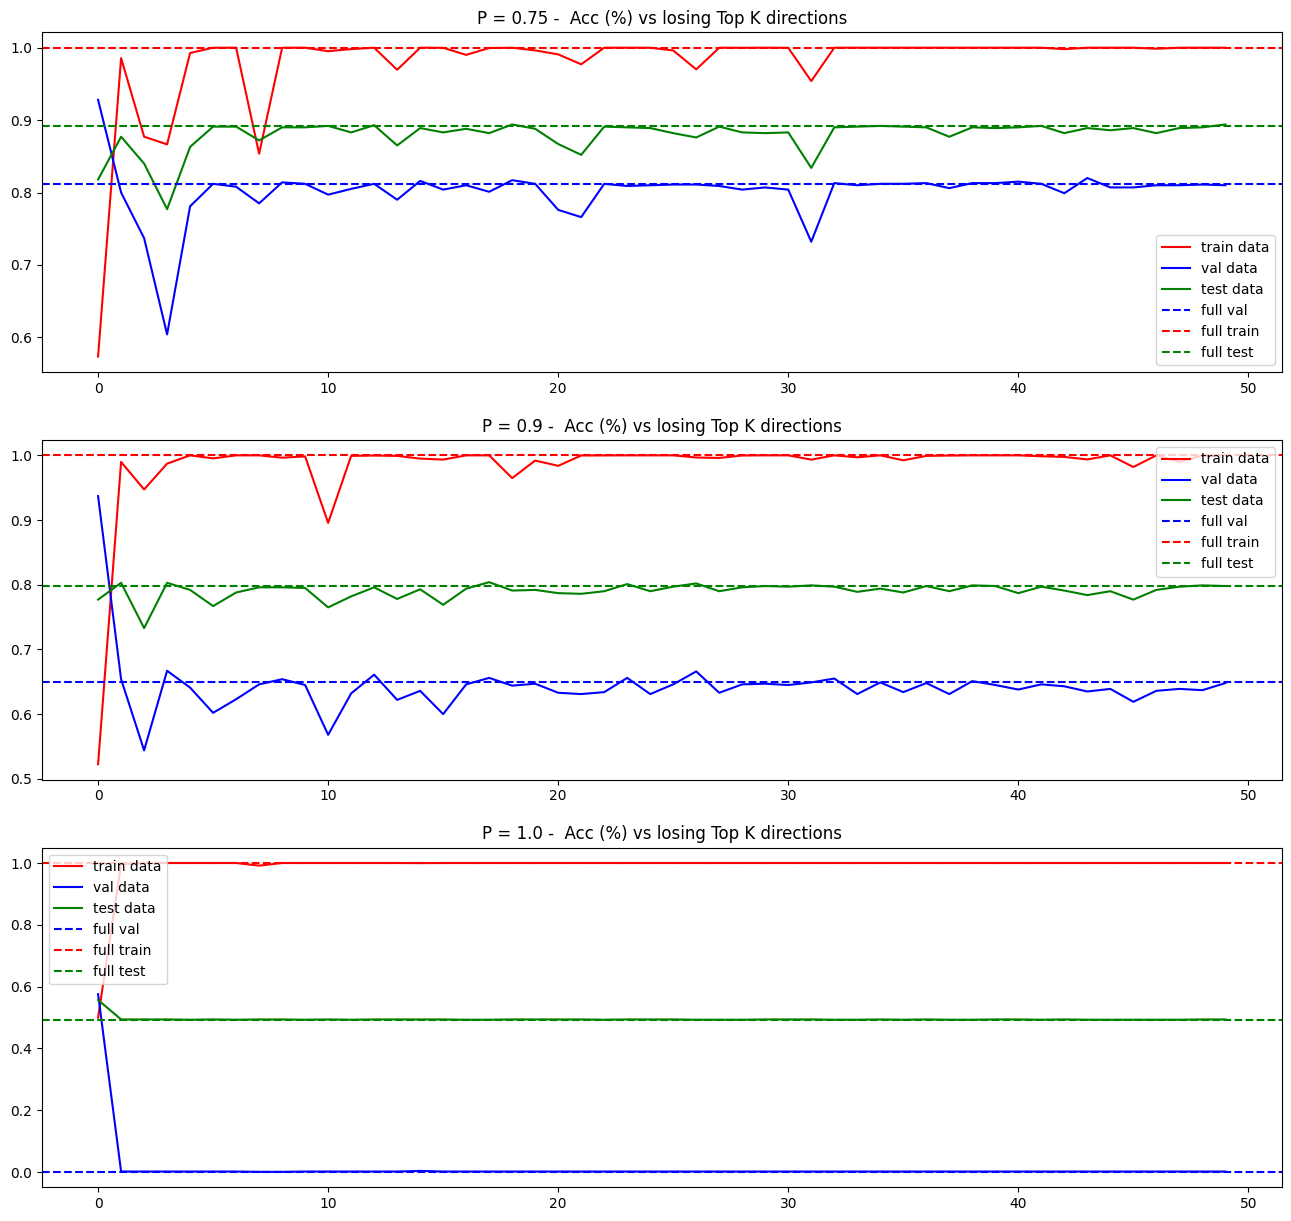

In [16]:
create_results_plot(r, a, caption=f" Acc (%) vs losing Top K directions")
   

In [30]:
%%time

r = dict()
a = dict()
args.output_dims = 1
modulations = list(np.arange(0,1.1,0.1))
model = simplecnn(args)
model.features.flatten.register_forward_hook(hook_fn)
results = dict()
accuracies = dict()

x_test, y_test = get_data(args, 0.0)

for corr in tqdm([0.0, 0.25,0.5,0.75, 0.9,1.0]):
    ruta = f"models/scnn_mnistcifar_{corr}_True_222_best_.pth"
    
    x, y = get_data(args, corr)
    x['test'] = x_test['val']
    y['test'] = y_test['val']

    accs, split_accs = modulate_result(x, y, ['train','val','test'], model, ruta, modulations, least=False)
    results[ruta] = accs
    accuracies[ruta] = split_accs
r = results
a = accuracies

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth


  0%|          | 0/6 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth


  0%|          | 0/11 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.25.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.25.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.25.pth


  0%|          | 0/11 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.5.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.5.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.5.pth


  0%|          | 0/11 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth


  0%|          | 0/11 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth


  0%|          | 0/11 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth


  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 8min 7s, sys: 32.7 s, total: 8min 40s
Wall time: 1min 8s


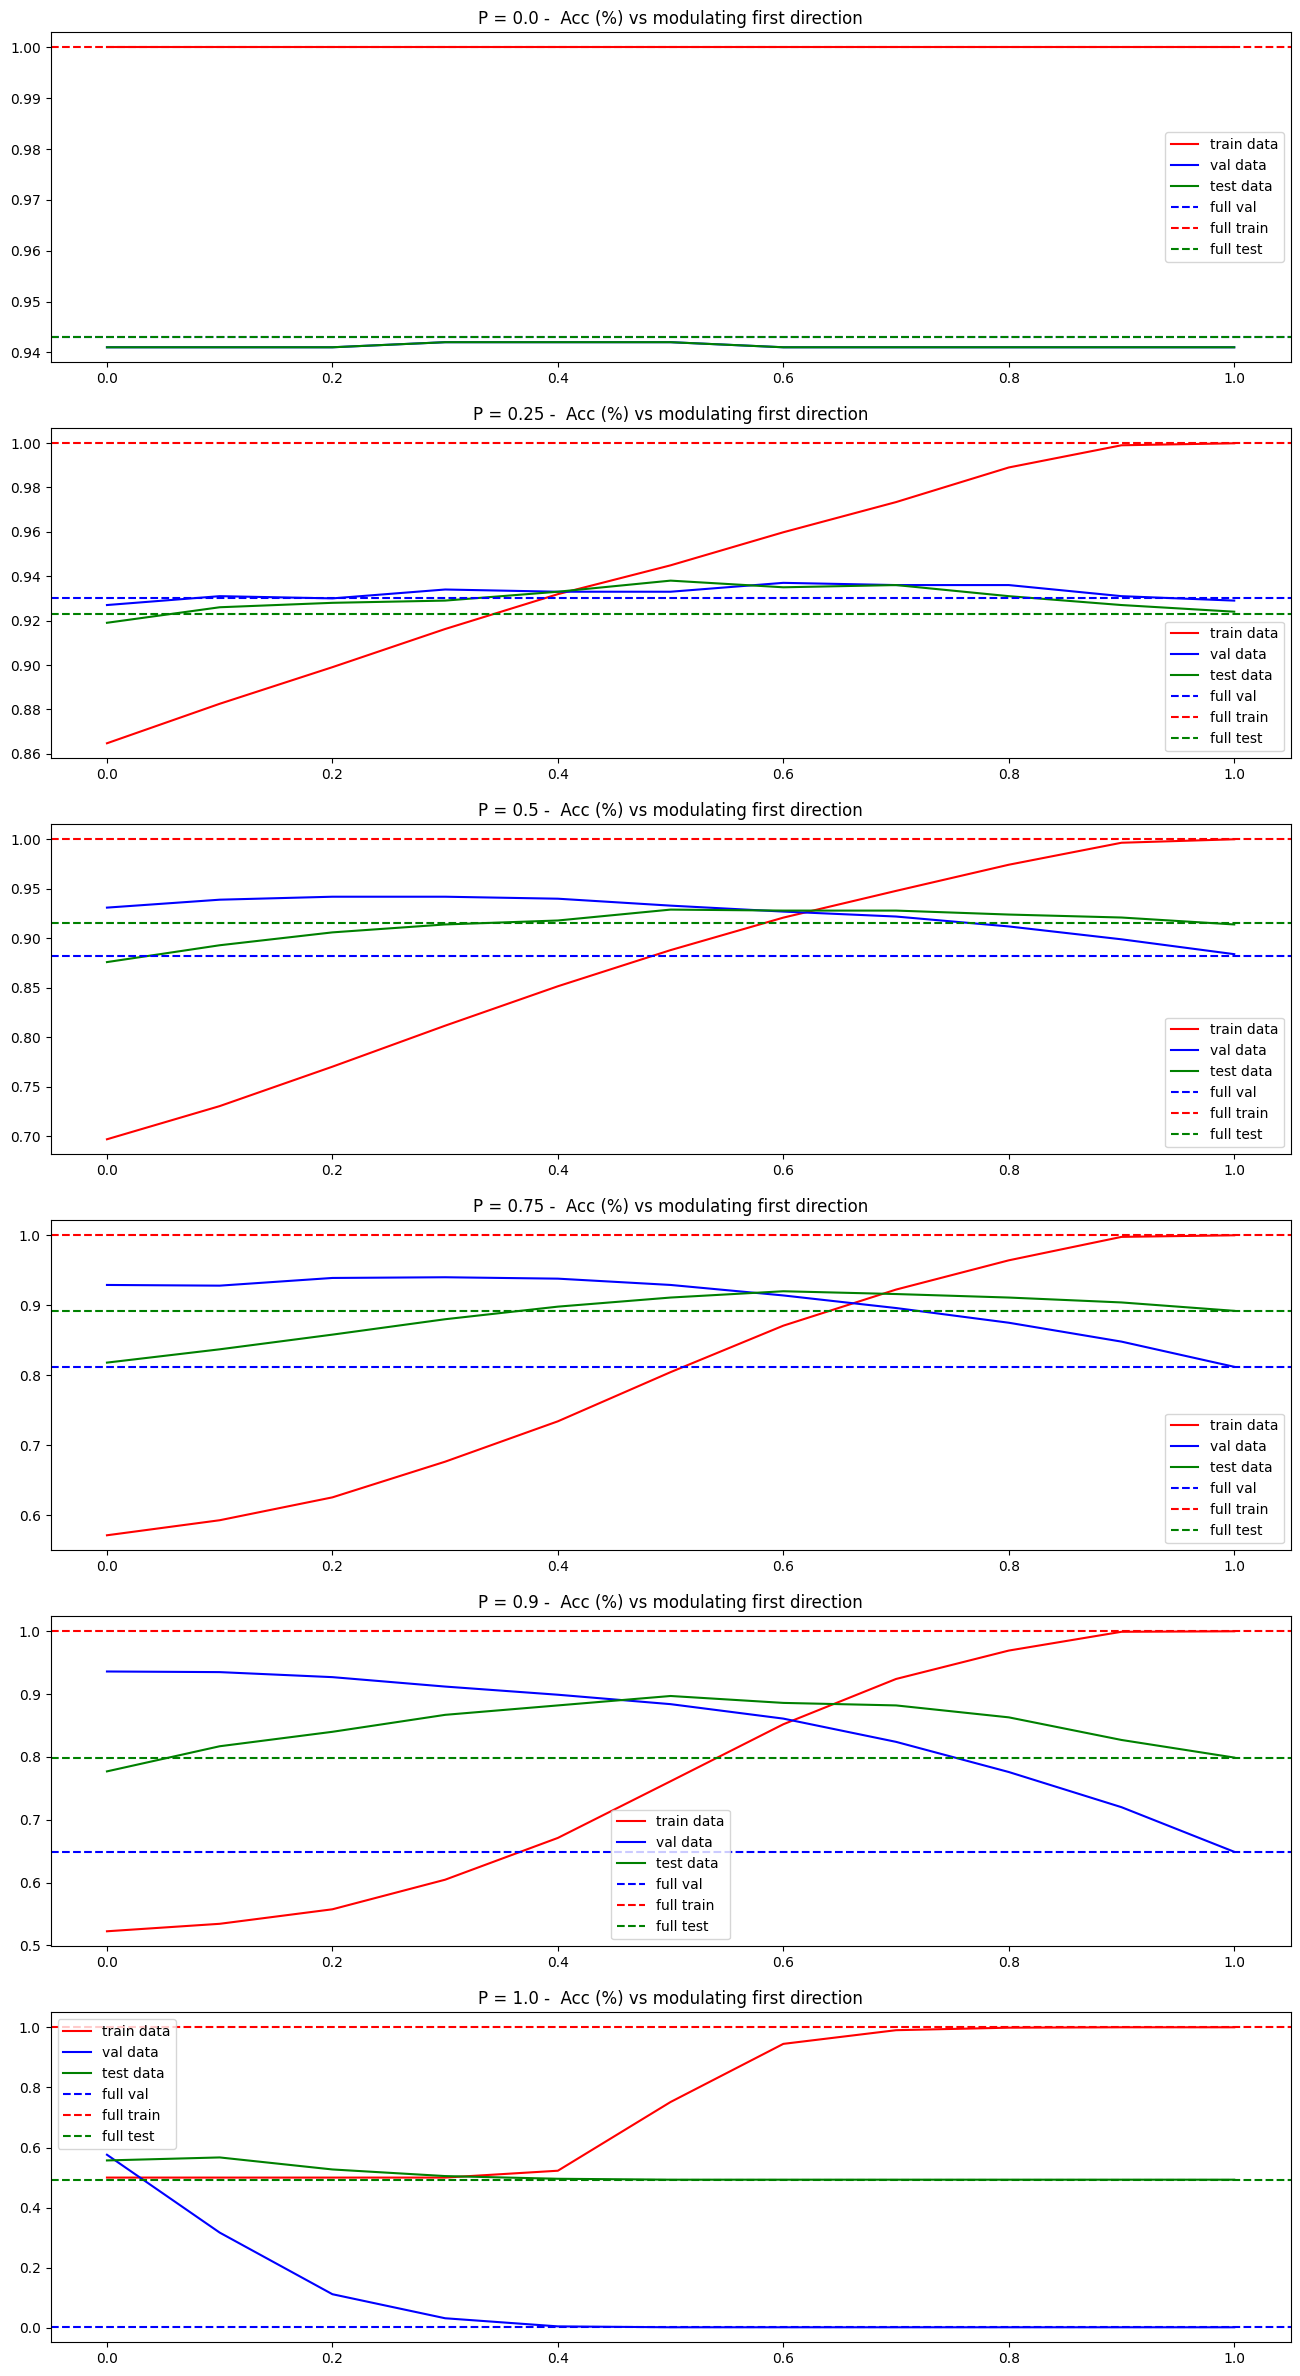

In [31]:
create_results_plot(r, a, caption=f" Acc (%) vs modulating first direction")
  

In [53]:

from IPython.display import display, Latex
table = defaultdict(dict)
for k, v in r.items():
    corr = k.split("_")[2]
    l = np.array(v['test'])
    max_idx = np.argmax(l)
    max_val = np.max(l)
    for split, val in v.items():
        st = f"{val[max_idx].item():.2f} ({max_idx/10})"
        table[corr][split] = st
pd.DataFrame.from_dict(table)

0.0        0.25         0.5        0.75         0.9         1.0
train  1.00 (0.3)  0.94 (0.5)  0.89 (0.5)  0.87 (0.6)  0.76 (0.5)  0.50 (0.1)
val    0.94 (0.3)  0.93 (0.5)  0.93 (0.5)  0.91 (0.6)  0.88 (0.5)  0.32 (0.1)
test   0.94 (0.3)  0.94 (0.5)  0.93 (0.5)  0.92 (0.6)  0.90 (0.5)  0.57 (0.1)

### Testing trained models on MNIST-CIFAR on MNIST






In [73]:
%%time
def eval_dataset(args, model, x, y):
    with torch.no_grad():
        acc_fn = get_accuracy_fn(args)
        return acc_fn(model(x), y)
    
# This function alters the classifier of a model
def model_surgery(model, train_data, k=0, l=0):
    # calculate representations
    classifier = deepcopy(model.state_dict()['fc.0.weight'].clone())
    old_bias = deepcopy(model.state_dict()['fc.0.bias'].clone())
    model(train_data)
    reps_train = model.output.clone().detach()
    mu_reps = reps_train.mean(dim=0)
    bias = model.state_dict()['fc.0.bias'].clone()
    U, S, V = torch.pca_lowrank(reps_train, center=True, q=4608)
    # Calculate pseudoinverse...
    p_inv = torch.linalg.pinv(V)   
    V_selected = V
    V_selected[:,k]*=l
    C_prime = torch.matmul(V_selected, p_inv)  # Project to k more important directions
    new_classifier = torch.matmul(C_prime, classifier.T).T
    sd = deepcopy(model.state_dict())
    sd['fc.0.weight'] = new_classifier
    sd['fc.0.bias'] += -torch.matmul(mu_reps, (classifier - new_classifier).T).T
    new_model = simplecnn(args)
    new_model.load_state_dict(sd)
    return new_model
# Initialize an empty dictionary to store the results
args.output_dims = 1
results = {}
root = f"../datasets/MNISTCIFAR/MNIST_CIFAR_0.0.pth"   
test_split = torch.load(root)['val']
# Iterate over the combinations
for corr in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
    print(corr)
    ruta = f"models/scnn_mnistcifar_{corr}_True_222_best_.pth"
    root = f"../datasets/MNISTCIFAR/MNIST_CIFAR_{corr}.pth"
    all_splits = torch.load(root)
    all_splits['test'] = test_split
    weights = torch.load(ruta)
    model = simplecnn(args)
    model.features.flatten.register_forward_hook(hook_fn)
    model.load_state_dict(weights['model'])
    model = model_surgery(model, all_splits['train']['data'], k=0, l=0)
    for t in ['targets', 'mnist']:
        train_result = eval_dataset(args, model, all_splits['train']['data'], all_splits['train'][t])
        val_result = eval_dataset(args, model, all_splits['val']['data'], all_splits['val'][t])
        test_result = eval_dataset(args, model, all_splits['test']['data'], all_splits['test'][t])
        results[(corr, t)] = [corr, t, train_result, val_result, test_result]



0.0
0.25
0.5
0.75
0.9


KeyboardInterrupt: 

In [72]:
import pandas as pd
# Create a DataFrame from the dictionary and set column names
df = pd.DataFrame.from_dict(results, orient='index', columns=['Correlation', 'Type', 'Train Result', 'Val Result', 'Test Result'])
df['Type'].replace({'targets': 'cifar'}, inplace=True)
df.columns = ['Correlation', 'Labels', 'Train Acc', 'Val Acc', 'Test Acc']
# Reset the index
df.reset_index(drop=True, inplace=True)
df

Correlation Labels  Train Acc  Val Acc  Test Acc
0          0.00  cifar    0.56424   0.5136    0.5136
1          0.00  mnist    0.42786   0.4340    0.4340
2          0.25  cifar    0.82626   0.6294    0.6818
3          0.25  mnist    0.62406   0.4660    0.5414
4          0.50  cifar    0.83980   0.5130    0.6460
5          0.50  mnist    0.73052   0.4340    0.5796
6          0.75  cifar    0.80372   0.3404    0.5540
7          0.75  mnist    0.75742   0.3916    0.5722
8          0.90  cifar    0.83328   0.2378    0.5224
9          0.90  mnist    0.81228   0.4524    0.6264
10         1.00  cifar    0.11504   0.1016    0.1114
11         1.00  mnist    0.11504   0.1104    0.1160

Correlation Labels  Train Acc  Val Acc  Test Acc
0         0.000  cifar      0.817    0.710     0.710
1         0.000  mnist      0.530    0.535     0.535
2         0.250  cifar      0.859    0.648     0.703
3         0.250  mnist      0.657    0.501     0.575
4         0.500  cifar      0.892    0.529     0.673
5         0.500  mnist      0.777    0.475     0.628
6         0.750  cifar      0.965    0.380     0.634
7         0.750  mnist      0.892    0.501     0.690
8         0.900  cifar      0.994    0.241     0.588
9         0.900  mnist      0.953    0.600     0.778
10        1.000  cifar      1.000    0.012     0.508
11        1.000  mnist      1.000    0.951     0.972

In [51]:
x = torch.randn((10000,3,64,32))

In [224]:
S tensor(887.5392)
cpu
V_selected tensor([-0.0016, -0.0016, -0.0022, -0.0022, -0.0012, -0.0012, -0.0022, -0.0022,
        -0.0033, -0.0033])
tensor([[ -3.4756,  10.2866, -12.2260,  ..., -11.1756,  -7.1958,  22.3667],
        [  2.7420,   4.6835,  -8.0218,  ..., -11.6524,   0.7242,  16.0845],
        [ -4.3339,   9.2772,  -0.0901,  ..., -10.0457,   0.6678,  16.0289],
        ...,
        [  0.9517,   7.7022,  -5.7349,  ...,   5.5884, -10.4739,  17.4363],
        [ -2.0561,  13.5978,  -9.2058,  ..., -11.4994,   7.8542,   7.4976],
        [  4.1242,   9.2299,  -6.6681,  ..., -16.2414,   1.6215,  21.1557]],

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [157]:
model.state_dict()['fc.0.weight'].shape

torch.Size([10, 4608])

In [207]:
for i in range(int(len(reps)/2)):
    print(reps[i].item(),reps[i+1].item())

0.06918644905090332 0.06918644905090332
0.06918644905090332 0.0688241496682167
0.0688241496682167 0.0688241496682167
0.0688241496682167 0.0687149167060852
0.0687149167060852 0.0687149167060852
0.0687149167060852 0.06703656911849976
0.06703656911849976 0.06703656911849976
0.06703656911849976 0.06594070792198181
0.06594070792198181 0.06594070792198181
0.06594070792198181 0.06638894975185394
0.06638894975185394 0.06638894975185394
0.06638894975185394 0.05356743931770325
0.05356743931770325 0.05356743931770325
0.05356743931770325 0.05760030448436737
0.05760030448436737 0.05760030448436737
0.05760030448436737 0.055174726992845535
0.055174726992845535 0.055174726992845535
0.055174726992845535 0.02944350615143776
0.02944350615143776 0.02944350615143776
0.02944350615143776 0.03500264137983322
0.03500264137983322 0.03500264137983322
0.03500264137983322 0.04319264739751816
0.04319264739751816 0.04319264739751816
0.04319264739751816 0.018900346010923386
0.018900346010923386 0.018900346010923386
0

In [158]:
for n in ['weight', 'bias']:
    print(model.state_dict()[f'fc.0.{n}'] == m.state_dict()[f'fc.0.{n}'])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([True, True, True, True, True, True, True, True, True, True])


split | on | Acc
-- | --  | --
train | 0 | 0.5734  
train | 1   | 1 
val | 0 | 0.9280  
val | 1   | 0.8120
test | 0 |  0.8180 
test | 1   | 0.8920 

In [51]:
print(model.state_dict()['features.conv1.weight'][0])
model_copy['features.conv1.weight'][0]

tensor([[[ 0.0993, -0.0369, -0.0457],
         [ 0.0576,  0.1652, -0.0349],
         [-0.0419,  0.0840, -0.0427]],

        [[ 0.2008, -0.1232, -0.1866],
         [ 0.1238,  0.0084, -0.0518],
         [ 0.0745, -0.1185, -0.0957]],

        [[ 0.0986,  0.0734,  0.0457],
         [ 0.1795,  0.0512, -0.1853],
         [-0.1457, -0.0799, -0.0029]]])


tensor([[[ 0.0970, -0.0174, -0.0374],
         [ 0.0643,  0.1937, -0.0262],
         [-0.0124,  0.1256, -0.0246]],

        [[ 0.1826, -0.1205, -0.1961],
         [ 0.1151,  0.0198, -0.0605],
         [ 0.0886, -0.0921, -0.0951]],

        [[ 0.0718,  0.0651,  0.0240],
         [ 0.1588,  0.0488, -0.2088],
         [-0.1425, -0.0672, -0.0177]]])

In [57]:
for k, v in a.items():
    for k1, v1 in v.items():
        v[k1] = v1.detach()


In [54]:
a

{'models/scnn_mnistcifar_0.75_True_222_best_.pth': {'train': tensor(0.0007, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  'val': tensor(1.1442, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  'test': tensor(0.7338, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)},
 'models/scnn_mnistcifar_0.9_True_222_best_.pth': {'train': tensor(0.0003, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  'val': tensor(2.4251, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  'test': tensor(1.3933, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)},
 'models/scnn_mnistcifar_1.0_True_222_best_.pth': {'train': tensor(1.7275e-07, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  'val': tensor(48.5009, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
  'test': tensor(24.4070, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)}}

In [9]:
r = dict()
a = dict()

iterations = {
    0.75: [ 1,  2,  3,  6, 13, 14, 17],
    0.9: [ 1,  2,  3,  6, 11, 13, 14, 15, 17, 33, 38, 39, 43, 44, 45]
}

results = dict()
accuracies = dict()

x_test, y_test = get_data(args, 0.0)

for corr in tqdm([0.75,0.9,1.0]):
    
    ruta = f"models/scnn_mnistcifar_{corr}_True_222_best_.pth"
    
    x, y = get_data(args, corr)
    x['test'] = x_test['val']
    y['test'] = y_test['val']
        
    accs, split_accs = calculate_multiple(x, y, ['train','val','test'], model, ruta, iterations[corr], least=False)
    results[ruta] = accs
    accuracies[ruta] = split_accs
r = results
a = accuracies

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.0.pth


  0%|          | 0/3 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_binary_1.0.pth


KeyError: 1.0

In [74]:
for k, v in r.items():
    print(k, v)

models/scnn_mnistcifar_0.75_222_best_.pth defaultdict(<class 'list'>, {'train': [tensor(0.7494)], 'val': [tensor(0.5384)]})
models/scnn_mnistcifar_0.9_222_best_.pth defaultdict(<class 'list'>, {'train': [tensor(0.6281)], 'val': [tensor(0.5402)]})


In [75]:
print(a)

{'models/scnn_mnistcifar_0.75_222_best_.pth': {'train': tensor(0.9104), 'val': tensor(0.5316), 'test': tensor(0.7242)}, 'models/scnn_mnistcifar_0.9_222_best_.pth': {'train': tensor(0.9993), 'val': tensor(0.5088), 'test': tensor(0.7242)}}


In [6]:
r

{'models/scnn_mnistcifar_0.75_True_222_best_.pth': defaultdict(list,
             {'train': [tensor(0.5725),
               tensor(0.9864),
               tensor(0.8752),
               tensor(0.8677),
               tensor(0.9934),
               tensor(1.),
               tensor(1.),
               tensor(0.8549),
               tensor(1.),
               tensor(1.),
               tensor(0.9945),
               tensor(0.9977),
               tensor(1.),
               tensor(0.9684),
               tensor(1.),
               tensor(1.),
               tensor(0.9910),
               tensor(0.9996),
               tensor(1.),
               tensor(0.9968),
               tensor(0.9899),
               tensor(0.9780),
               tensor(1.),
               tensor(1.),
               tensor(1.),
               tensor(0.9954),
               tensor(0.9690),
               tensor(1.),
               tensor(0.9999),
               tensor(1.),
               tensor(0.9998),
             

In [7]:
a

{'models/scnn_mnistcifar_0.75_True_222_best_.pth': {'train': tensor(1.),
  'val': tensor(0.8120),
  'test': tensor(0.8920)},
 'models/scnn_mnistcifar_0.9_True_222_best_.pth': {'train': tensor(1.),
  'val': tensor(0.6490),
  'test': tensor(0.7980)},
 'models/scnn_mnistcifar_1.0_True_222_best_.pth': {'train': tensor(1.),
  'val': tensor(0.0020),
  'test': tensor(0.4930)}}

In [18]:
r = dict()
a = dict()

iterations = list(range(50))
args.output_dims = 10
model = simplecnn(args)
model.features.flatten.register_forward_hook(hook_fn)
results = dict()
accuracies = dict()

x_test, y_test = get_data(args, 0.0)

for corr in tqdm([0.75, 0.9,1.0]):
    ruta = f"models/scnn_mnistcifar_{corr}_False_222_best_.pth"
    
    x, y = get_data(args, corr)
    x['test'] = x_test['val']
    y['test'] = y_test['val']
        
    accs, split_accs = calculate_result(x, y, ['train','val','test'], model, ruta, iterations, least=False)
    results[ruta] = accs
    accuracies[ruta] = split_accs
r = results
a = accuracies

../datasets/MNISTCIFAR/MNIST_CIFAR_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_0.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_0.0.pth


  0%|          | 0/3 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_0.75.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_0.75.pth


  0%|          | 0/50 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_0.9.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_0.9.pth


  0%|          | 0/50 [00:00<?, ?it/s]

../datasets/MNISTCIFAR/MNIST_CIFAR_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_1.0.pth
../datasets/MNISTCIFAR/MNIST_CIFAR_1.0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

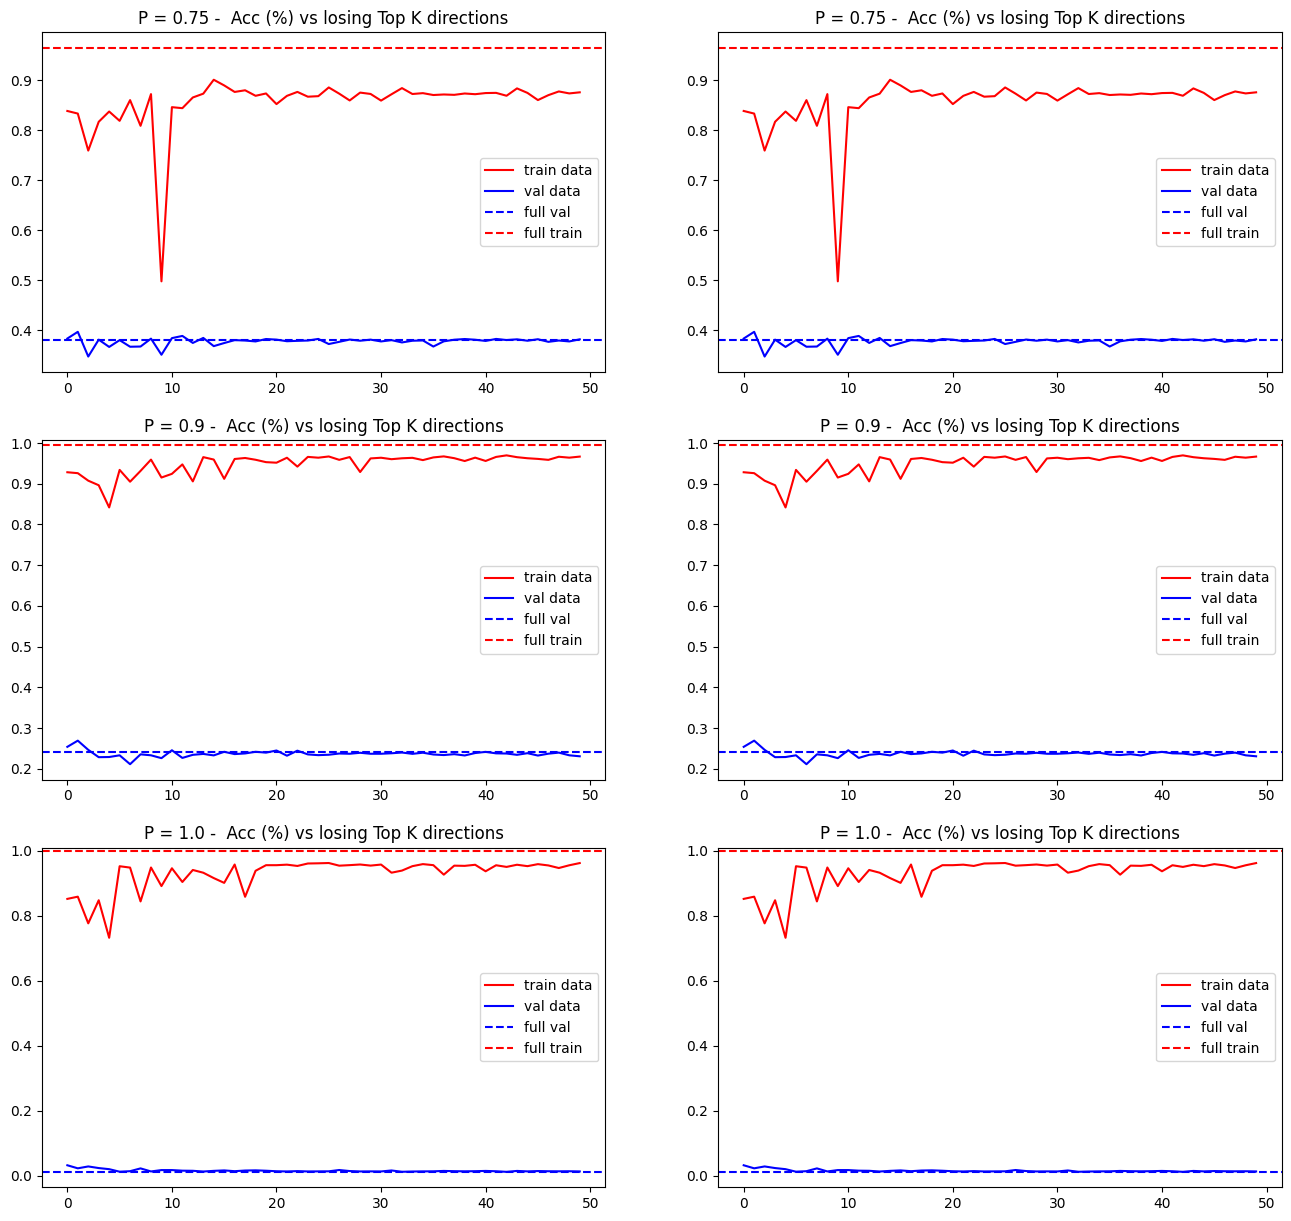

In [19]:
create_results_plot(r, a, caption=f" Acc (%) vs losing Top K directions")

In [70]:
ruta = 'models/scnn_mnistcifar_0.75_222_best_.pth'
torch.tensor(r[ruta]['val'])> a[ruta]['val']

indices = torch.nonzero(torch.tensor(r[ruta]['val'])> a[ruta]['val']).squeeze()

print(indices)


tensor([ 1,  2,  3,  6, 13, 14, 17])


In [69]:
ruta = 'models/scnn_mnistcifar_0.9_222_best_.pth'

# Get the indices where the tensor is True
indices = torch.nonzero(torch.tensor(r[ruta]['val'])> a[ruta]['val']).squeeze()

print(indices)


tensor([ 1,  2,  3,  6, 11, 13, 14, 15, 17, 33, 38, 39, 43, 44, 45])


In [26]:
import numpy as np
import pandas as pd
df = pd.DataFrame(columns=['Corr', 'K', 'Max_Value', 'Mean_Val_Acc'])


rutas = [
     "models/scnn_mnistcifar_0.75_222_best_.pth",
     "models/scnn_mnistcifar_0.9_222_best_.pth"
 #   f"models/scnn_synmnist_0.625_{bg}_nobs_cmnist_baseline.pth",
 #   f"models/scnn_synmnist_0.75_{bg}_nobs_cmnist_baseline.pth",
 #   f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth",
 #   f"models/scnn_synmnist_0.95_{bg}_nobs_cmnist_baseline.pth",
 #   f"models/scnn_synmnist_1_{bg}_nobs_cmnist_baseline.pth"
]
for ruta in rutas:
    mean_tr_acc = a[ruta]['train']
    mean_val_acc = a[ruta]['val']
    val_values = np.array(r[ruta]['val'])
    train_values = np.array(r[ruta]['train'])
    new_values = np.minimum(train_values, val_values)
    max_index = np.argmax(new_values)
    max_value = np.max(new_values)
    # Create a new row and append it to the DataFrame
    new_row = pd.DataFrame({
        'Corr': [str(round(float(ruta.split("_")[2])*2-1, 2))],
        'K': [max_index],
        'Max_Value': [max_value],
        'Mean_Val_Acc': [float(mean_val_acc)]
    })
    df = pd.concat([df, new_row], ignore_index=True)

print(df)

  Corr  K  Max_Value  Mean_Val_Acc
0  0.5  0     0.7374        0.7322
1  0.8  0     0.7252        0.7242


In [63]:
a

{'models/scnn_mnistcifar_0.75_222_best_.pth': {'train': tensor(0.9104),
  'val': tensor(0.5316),
  'test': tensor(0.7242)},
 'models/scnn_mnistcifar_0.9_222_best_.pth': {'train': tensor(0.9993),
  'val': tensor(0.5088),
  'test': tensor(0.7242)},
 'models/scnn_mnistcifar_1.0_222_best_.pth': {'train': tensor(0.9702),
  'val': tensor(0.4764),
  'test': tensor(0.7242)}}

## Histogram of values for train and val data

p = 0.875

In [27]:
accuracies

{'models/scnn_mnistcifar_0.75_222_best_.pth': {'train': tensor(0.7553),
  'val': tensor(0.7322)},
 'models/scnn_mnistcifar_0.9_222_best_.pth': {'train': tensor(0.7311),
  'val': tensor(0.7242)}}

In [3]:
from collections import defaultdict
bg = 'nobg'

ruta = f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth"

# Get dataloaders
task_args.dataset = {'name': 'synmnist', 'p': 0.875 ,
                 'bg': bg,
                 'splits': ['train','val','test'],
                 'baseline': False, 'bs': 16000}
for k,v in task_args.items():
    args['task_bg'] = bg

args.task_args = task_args

dls = make_dataloaders(args)
x = defaultdict(list)
y = defaultdict(list)

for split in ['train', 'val','test']:
    for xs,ys  in dls['task'][split]:
        x[split].append(xs)
        y[split].append(ys)

    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])


Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.


In [6]:

# Load model to evaluate
weights = torch.load(ruta)
model.load_state_dict(weights)
# calculate representations
def get_representations(model, x):
    rs = dict()
    model(x['train'])
    rs['train'] = model.output.clone().detach()
    reps_mean = rs['train'].mean(dim=0).clone()
    rs['train'] -= reps_mean
    model(x['val'])
    rs['val'] = model.output.clone().detach()
    rs['val'] -= reps_mean
    model(x['test'])
    rs['test'] = model.output.clone().detach()
    rs['test'] -= reps_mean
    return rs

def split_representations(rs):
    reps = defaultdict(dict)
    indices = defaultdict(dict)

    for split in ['train','val','test']:
        for c in [0,1]:
            reps[split][c] = rs[split][y[split] == c]
            indices[split][c] = torch.where((y[split] == c) > 0)[0]
    return reps, indices

def get_logits(reps, V):
    logits = defaultdict(dict)
    with torch.no_grad():
        for split in ['train','val']:
            for c in [0,1]:
                logits[split][c] = torch.matmul(reps[split][c], V)  # Project to k most important directions
    return logits
rs = get_representations(model, x)
reps, indices = split_representations(rs)



In [8]:
# Get train eigenvectors
U, S, V = torch.pca_lowrank(rs['train'], center=True, q=1000)
y_test = y['val']
logits = get_logits(reps, V)

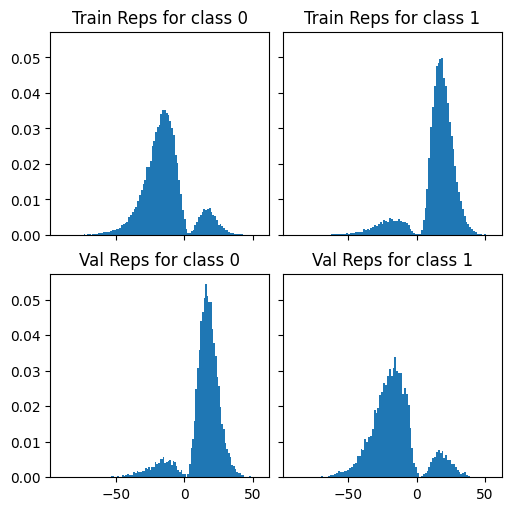

In [11]:
bins = 100
k=0
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,constrained_layout=True)
fig.set_size_inches(5,5)

for i, split in enumerate(['train','val']):
    for c in [0,1]:
        axs[i,c].hist(logits[split][c][:,k], bins, density=True)
        axs[i,c].set_title(f"{split.capitalize()} Reps for class {c}")

In [4]:
from torchvision.transforms import Normalize

def plot_images_grid(images, num_images):
    # Generate random indices to select images
    indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Select the images using the indices
    selected_images = images[indices]

    # Create a square grid for plotting
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))

    # Plot the images on the grid
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            image = selected_images[i].numpy().transpose(1, 2, 0)
            ax.imshow(image)
            ax.axis('off')
        else:
            ax.axis('off')

    # Adjust spacing and display the plot
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    return fig



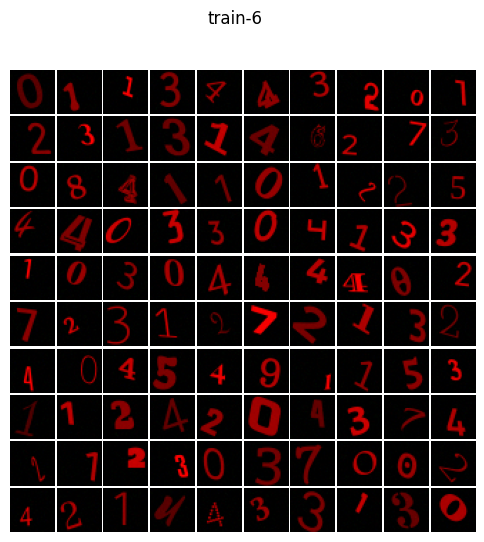

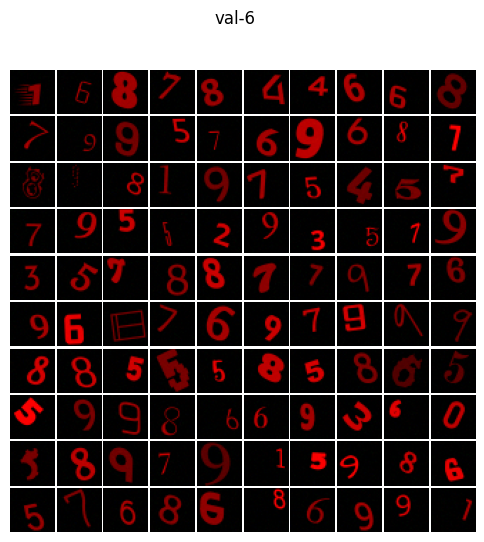

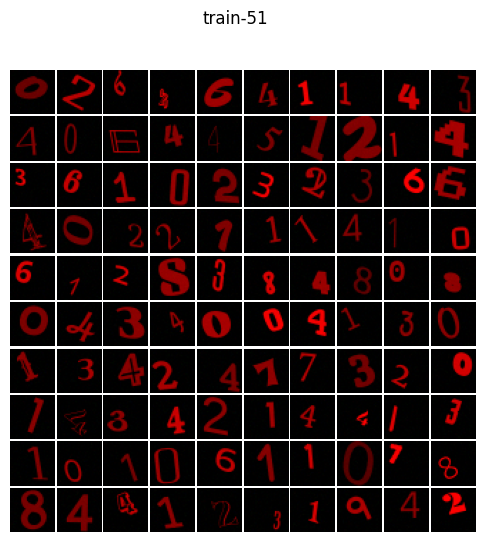

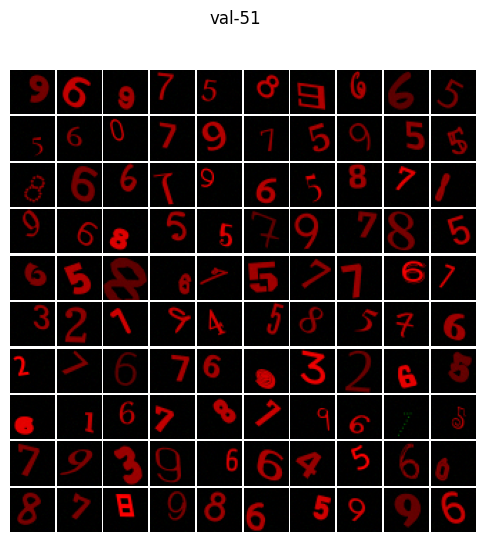

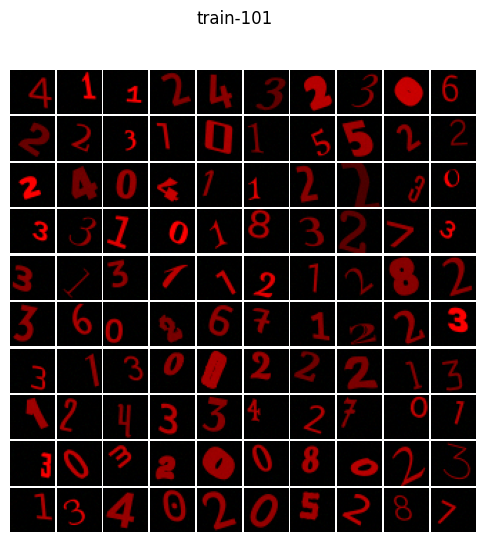

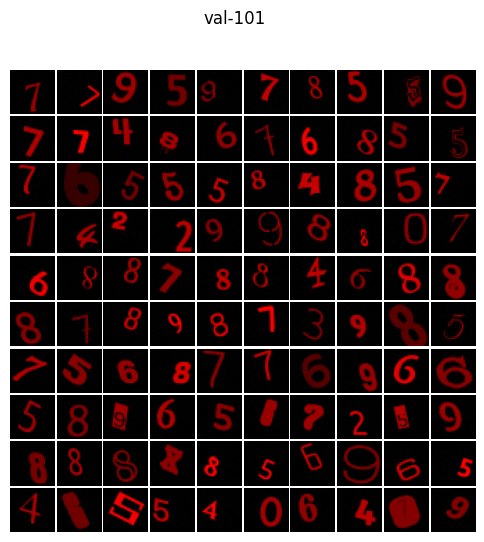

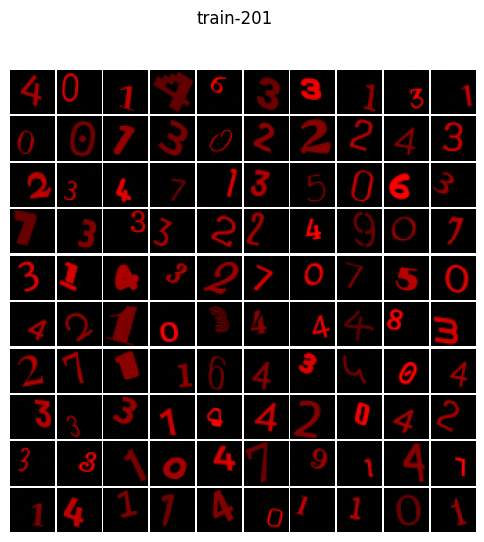

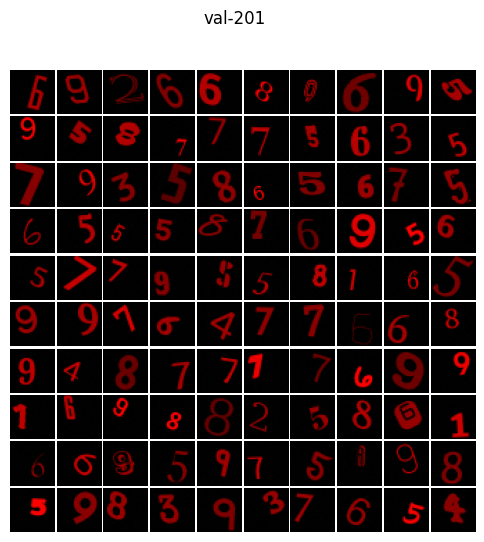

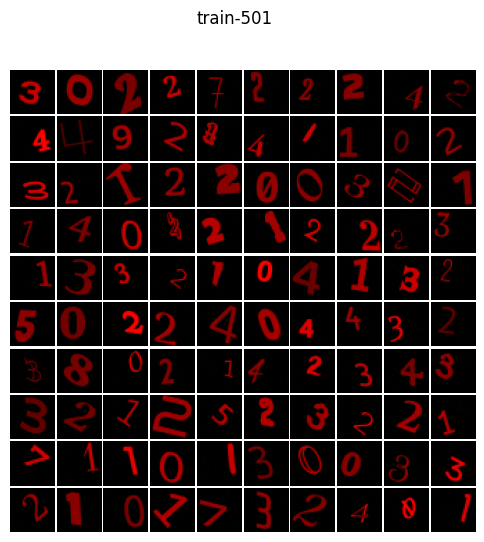

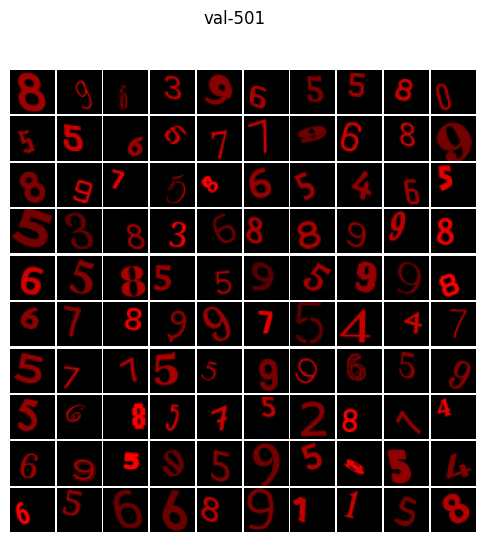

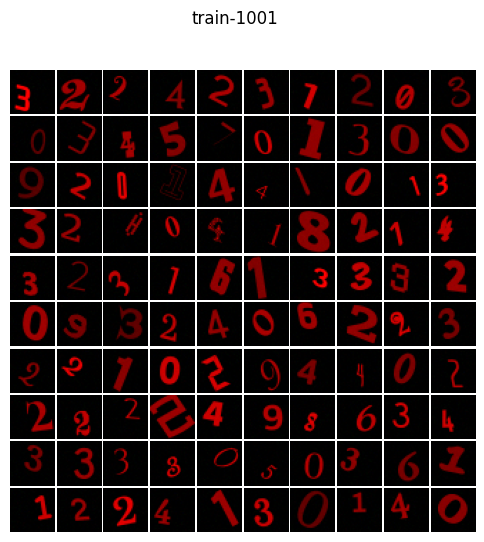

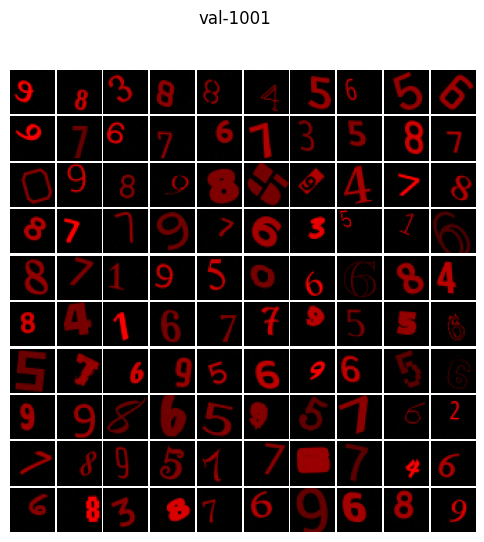

In [14]:
import numpy as np
t = Normalize([-1] *3, [2] *3)
rutas = [6,51,101,201,501,1001]
for i in rutas:
    ruta = f'models/scnn_synmnist_0.875_nobg_nobs_nofrz_{i}_cmnist_baseline.pth'
    # Load model to evaluate
    weights = torch.load(ruta)
    model.load_state_dict(weights)
    
    rs = get_representations(model, x)
    # Get train eigenvectors
    U, S, V = torch.pca_lowrank(rs['train'], center=True, q=1000)
    reps, indices = split_representations(rs)
    logits = get_logits(reps, V)
    
    for split in ['train','val']:
        images = []
        for c in [0,1]:
            indices_temp = torch.where(logits[split][c][:,0] <= 0)[0]
            images.append(t(x[split][indices[split][c]][indices_temp]))

        images = torch.concat(images)

        fig = plot_images_grid(images, 100)
        fig.suptitle(f'{split}-{i}')

### Ablation: Modulating the strength of the spurious correlation

In [48]:
# Give a set of directions to eliminate get acc on train_val
import numpy as np
import pandas as pd
temp_logits = dict()
mask = torch.ones_like(V)
#indices = [3]
#mask[:,indices] = 0 # Turn off selected indices
''''''

#f_V = V[mask.bool()].view(-1, 1000-len(indices))
f_V = V.clone()

p_inv = torch.linalg.pinv(f_V)
temp_reps = dict()

rutas = [
    f"models/scnn_synmnist_0.5_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.625_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.75_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.95_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_1_{bg}_nobs_cmnist_baseline.pth"
]
df = pd.DataFrame(columns=['Lambda', 'Train', 'Val', 'Test'])
for l in np.arange(0,1.1,0.1):
    with torch.no_grad():
        line = {'Lambda': [l]}
        for split in ['train','val','test']:
            model(x[split])
            temp_reps[split] = model.output
      
        for split in ['train','val','test']:
            temp_logits[split] = torch.matmul(temp_reps[split], f_V)  # Project to k most important directions
            temp_logits[split][:,0]*= l
            temp_logits[split] = torch.matmul(temp_logits[split],p_inv)
            temp_logits[split] += reps_mean
            temp_logits[split] = model.fc(temp_logits[split])             # Pass through classifier for result
            # Create a new row and append it to the DataFrame
            line[split.capitalize()] = [mean_accuracy(temp_logits[split],y[split]).item()]
        
        new_row = pd.DataFrame(line)
        df = pd.concat([df, new_row], ignore_index=True)
            


In [49]:
# Set the desired format
pd.options.display.float_format = '{:.3f}'.format
df['Lambda'] = df['Lambda'].map(lambda x: '{:.1f}'.format(x))
df

Lambda  Train   Val  Test
0     0.0  0.740 0.873 0.874
1     0.1  0.781 0.865 0.865
2     0.2  0.820 0.856 0.856
3     0.3  0.854 0.840 0.842
4     0.4  0.884 0.822 0.822
5     0.5  0.906 0.799 0.800
6     0.6  0.923 0.770 0.772
7     0.7  0.936 0.736 0.743
8     0.8  0.941 0.701 0.710
9     0.9  0.943 0.663 0.667
10    1.0  0.941 0.621 0.626

## Baselines Magnitude, Gradient Sign

In [2]:
def evaluate(model, x, y):
    with torch.no_grad():
        logits = model(x)
        return mean_accuracy(logits, y)
    
    
def magnitude_selection(mask, tensors, ratio):
    tensors = deepcopy(tensors)
    combined_mask = torch.cat([mask_tensor.flatten() for mask_tensor in mask.values()]).cpu()
    combined_tensors = torch.cat([tensor.flatten() for tensor in tensors.values()]).cpu()
    #comb_tens_zeros = torch.zeros_like(combined_tensors)
    magnitudes = torch.abs(combined_tensors) * combined_mask.float()
    nonzero_mask = magnitudes != 0
    magnitudes[magnitudes == 0] = 10000
    # Get the magnitudes of the selected non-zero values

    # Get the number of values to select based on the given percentage and the count of non-zero values in the combined mask
    num_values = int(torch.sum(nonzero_mask) * (ratio))

    # Get the indices of the non-zero values with the smallest magnitudes
    sorted_indices = torch.argsort(magnitudes, descending=False)

    # Create a new mask with the selected values
    new_combined_mask = torch.zeros_like(combined_mask)
    new_combined_mask[nonzero_mask] = 1
    new_combined_mask[sorted_indices[num_values:]] = 0

    # Reshape the new mask to match the shape of the combined mask
    #new_combined_mask = new_combined_mask.reshape(combined_mask.shape)

    # Split the new mask into individual masks for each dictionary
    new_mask = {}
    index = 0
    for key in mask.keys():
        num_elements = mask[key].numel()
        new_mask[key] = new_combined_mask[index:index+num_elements].reshape(mask[key].shape)
        index += num_elements

    return new_mask

### Magnitude Pruning (Zero, Reinitialize weights)

In [66]:
from masks import forget_model, generate_mask_percentile_partial, generate_mask_percentile_full, generate_mask
from copy import deepcopy
baseline_results =  defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for method in ['reinitialize', 'zero']:
    for asc in [True, False]:
        for ratio in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            accs = dict()
            model.load_state_dict(old_weights)
            mask = generate_mask_percentile_full(old_weights, ratio, asc=asc)
            model = forget_model(args,model, mask, forget_method=method)

            accs['train'] = float(evaluate(model, x['train'], y['train']))
            accs['test'] = float(evaluate(model, x['val'], y['val']))
            baseline_results[method][asc][ratio] = deepcopy(accs)

Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30.00% of weights
Forgetting: 40.00% of weights
Forgetting: 50.00% of weights
Forgetting: 60.00% of weights
Forgetting: 70.00% of weights
Forgetting: 80.00% of weights
Forgetting: 90.00% of weights
Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30.00% of weights
Forgetting: 40.00% of weights
Forgetting: 50.00% of weights
Forgetting: 60.00% of weights
Forgetting: 70.00% of weights
Forgetting: 80.00% of weights
Forgetting: 90.00% of weights
Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30.00% of weights
Forgetting: 40.00% of weights
Forgetting: 50.00% of weights
Forgetting: 60.00% of weights
Forgetting: 70.00% of weights
Forgetting: 80.00% of weights
Forgetting: 90.00% of weights
Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30

In [67]:
import pandas as pd

# Assuming baseline_results is the nested defaultdict
# Convert the defaultdict to a regular dictionary
baseline_results_dict = dict(baseline_results)

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict({(method, asc, ratio): values for method, inner_dict in baseline_results_dict.items()
                             for asc, inner_dict2 in inner_dict.items()
                             for ratio, values in inner_dict2.items()}, orient='index')

# Reset the index and rename the columns
df.reset_index(inplace=True)
df.rename(columns={'level_0': 'Method', 'level_1': 'asc', 'level_2': 'ratio'}, inplace=True)

# Print the DataFrame
print(df)
# Use pivot_table to expand the table
from IPython.display import display, Latex
pivot_table = df.pivot_table(index="ratio", columns=["Method", "asc"], values=["test","train"], aggfunc="first")
late =df.to_latex()
print(late)

          Method    asc  ratio     train     test
0   reinitialize   True   0.01  0.679775  0.76260
1   reinitialize   True   0.10  0.826775  0.23135
2   reinitialize   True   0.20  0.470187  0.57475
3   reinitialize   True   0.30  0.487750  0.53205
4   reinitialize   True   0.40  0.405050  0.61730
5   reinitialize   True   0.50  0.495912  0.51450
6   reinitialize   True   0.60  0.502988  0.50025
7   reinitialize   True   0.70  0.503475  0.51455
8   reinitialize   True   0.80  0.534525  0.50085
9   reinitialize   True   0.90  0.448025  0.53390
10  reinitialize  False   0.01  0.570800  0.52030
11  reinitialize  False   0.10  0.499512  0.50130
12  reinitialize  False   0.20  0.464750  0.54895
13  reinitialize  False   0.30  0.485738  0.50550
14  reinitialize  False   0.40  0.500600  0.49840
15  reinitialize  False   0.50  0.649800  0.32830
16  reinitialize  False   0.60  0.500475  0.49870
17  reinitialize  False   0.70  0.500462  0.49870
18  reinitialize  False   0.80  0.569188  0.42750


### Focus on same/different sign gradients

In [62]:
from copy import deepcopy

from masks import forget_model, generate_mask, add_masks, generate_random_mask, generate_mask_percentile_full, generate_sign_mask
baseline_results =  defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for method in ['reinitialize','zero']:
    for asc in [True,False]:
        for ratio in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            print(ratio)
            accs = dict()
            model.load_state_dict(old_weights)
            mask = generate_mask(input_for_mask, method='spur_grads', t=0.1, asc=asc)
            # keep ratio weights that are not on the mask
            mask = magnitude_selection(mask, old_weights ,ratio)
            model = forget_model(args, model, mask, forget_method=method)
            accs['train'] = float(evaluate(model, x['train'], y['train']))
            accs['test'] = float(evaluate(model, x['val'], y['val']))
            baseline_results[method][asc][ratio] = deepcopy(accs)

0.01
Forgetting: 0.81% of weights
0.1
Forgetting: 8.13% of weights
0.2
Forgetting: 16.26% of weights
0.3
Forgetting: 24.38% of weights
0.4
Forgetting: 32.51% of weights
0.5
Forgetting: 40.64% of weights
0.6
Forgetting: 48.77% of weights
0.7
Forgetting: 56.90% of weights
0.8
Forgetting: 65.02% of weights
0.9
Forgetting: 73.15% of weights
0.01
Forgetting: 0.36% of weights
0.1
Forgetting: 3.60% of weights
0.2
Forgetting: 7.20% of weights
0.3
Forgetting: 10.80% of weights
0.4
Forgetting: 14.39% of weights
0.5
Forgetting: 17.99% of weights
0.6
Forgetting: 21.59% of weights
0.7
Forgetting: 25.19% of weights
0.8
Forgetting: 28.79% of weights
0.9
Forgetting: 32.39% of weights
0.01
Forgetting: 0.81% of weights
0.1
Forgetting: 8.13% of weights
0.2
Forgetting: 16.26% of weights
0.3
Forgetting: 24.38% of weights
0.4
Forgetting: 32.51% of weights
0.5
Forgetting: 40.64% of weights
0.6
Forgetting: 48.77% of weights
0.7
Forgetting: 56.90% of weights
0.8
Forgetting: 65.02% of weights
0.9
Forgetting: 73

tensor([1, 3, 4, 5])
tensor([], dtype=torch.int64)
{'mask1': tensor([[ True, False,  True],
        [ True,  True, False]]), 'mask2': tensor([[False, False, False],
        [False, False, False]])}


In [65]:
import pandas as pd

# Assuming baseline_results is the nested defaultdict
# Convert the defaultdict to a regular dictionary
baseline_results_dict = dict(baseline_results)

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict({(method, asc, ratio): values for method, inner_dict in baseline_results_dict.items()
                             for asc, inner_dict2 in inner_dict.items()
                             for ratio, values in inner_dict2.items()}, orient='index')

# Reset the index and rename the columns
df.reset_index(inplace=True)
df.rename(columns={'level_0': 'Method', 'level_1': 'asc', 'level_2': 'ratio'}, inplace=True)

# Print the DataFrame
print(df)
# Use pivot_table to expand the table
from IPython.display import display, Latex
pivot_table = df.pivot_table(index="ratio", columns=["Method", "asc"], values=["test","train"], aggfunc="first")

print(pivot_table)
late =df.to_latex()
print(late)

          Method    asc  ratio     train     test
0   reinitialize   True   0.01  0.728625  0.60585
1   reinitialize   True   0.10  0.659863  0.41490
2   reinitialize   True   0.20  0.316287  0.73850
3   reinitialize   True   0.30  0.531337  0.53405
4   reinitialize   True   0.40  0.562450  0.48135
5   reinitialize   True   0.50  0.555062  0.50645
6   reinitialize   True   0.60  0.397800  0.65965
7   reinitialize   True   0.70  0.270200  0.74070
8   reinitialize   True   0.80  0.485725  0.52925
9   reinitialize   True   0.90  0.425875  0.58800
10  reinitialize  False   0.01  0.919513  0.69220
11  reinitialize  False   0.10  0.895712  0.55165
12  reinitialize  False   0.20  0.603025  0.65450
13  reinitialize  False   0.30  0.460512  0.80025
14  reinitialize  False   0.40  0.865875  0.40615
15  reinitialize  False   0.50  0.558487  0.45425
16  reinitialize  False   0.60  0.638788  0.58180
17  reinitialize  False   0.70  0.610187  0.63815
18  reinitialize  False   0.80  0.698650  0.53525


In [8]:
# Use pivot_table to expand the table
from IPython.display import display, Latex

pivot_table = df.pivot_table( columns=["Method", "asc"], values=["test","train"], aggfunc="first")

late =pivot_table.to_latex()

print(late)
display(Latex(late))

\begin{tabular}{lrrrr}
\toprule
Method & \multicolumn{2}{r}{reinitialize} & \multicolumn{2}{r}{zero} \\
asc & False & True & False & True \\
\midrule
test & 0.457400 & 0.468050 & 0.501300 & 0.638800 \\
train & 0.560838 & 0.534550 & 0.499525 & 0.407300 \\
\bottomrule
\end{tabular}



<IPython.core.display.Latex object>

## Camelyon17


In [1]:
import torch
from models import simplecnn, densenet
from dataset import get_spurious_samples, make_dataloaders
from easydict import EasyDict  as edict
from torchvision.transforms import ToTensor, Normalize, Compose
from collections import defaultdict
from train import get_gradients_from_data
from copy import deepcopy


def mean_accuracy(logits, y):
    preds = (logits.squeeze() > 0.).float()
    return  ((preds - y).abs() < 1e-2).float().mean()

task_args = edict()
args = edict()
args.eval_datasets = dict()
task_args.mode = ["task"
                   #, 'play'
                  # ,'forget'
                   ]
args.dataset_paths = {'synmnist': "SynMNIST", "camelyon": "../datasets"}
task_args.dataset = {'name': 'camelyon', 'splits': ['id_val'], 'bs': 32}
splits = ['id_val','val','test']
args.eval_datasets['task'] = {'name': 'camelyon', 'splits': splits, 'bs': 1024}

args.model='densenet'
for k,v in task_args.items():
    args['task_'+k] = v
    
args.task_args = task_args

dls = make_dataloaders(args)

x = defaultdict(list)
y = defaultdict(list)

'''for split in ['id_val', 'val']:
    for xs,ys  in dls['eval']['task'][split]:
        x[split].append(xs)
        y[split].append(ys)
        
    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])
'''

# Cargar modelo preentrenado
#ruta = "models/scnn_synmnist_0.875_nobg_nobs_nofrz_1001_cmnist_baseline.pth"
#ruta = "models/scnn_synmnist_0.875_nobg_nobs_nofrz_101_cmnist_baseline.pth"
#weights = torch.load(ruta)
#old_weights = weights

#model = simplecnn(args)
#model.load_state_dict(weights)
#model = model

"for split in ['id_val', 'val']:\n    for xs,ys  in dls['eval']['task'][split]:\n        x[split].append(xs)\n        y[split].append(ys)\n        \n    x[split] = torch.cat(x[split])\n    y[split] = torch.cat(y[split])\n"

In [185]:

from train import evaluate
from models import simplecnn, densenet
# Cargar modelo preentrenado
ruta = "models/densenet_None_nofrz_22001_111_.pth"
weights = torch.load(ruta)
old_weights = weights

model = densenet(args)
model.load_state_dict(weights)
model = model

# Registrar hook para obtener valores intermedios
def hook_fn(module, input, output):
    out = F.relu(output, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    model.output = out

#print(dir(model))
model.features.register_forward_hook(hook_fn)

In [186]:
# Evaluate model on splits
model = model.cuda()
results = dict()
for split in splits:
    results[split] = evaluate(model, dls['eval']['task'][split], caption=split)
    
model = model.cpu()

[TEST       ] [05208/85054 (6%)] Loss: 0.585 Acc: 75.55%5%

In [187]:
results

{'id_val': {'id_val_loss': 0.09715906530618668,
  'id_val_acc': 96.85041809082031},
 'val': {'val_loss': 0.33525240421295166, 'val_acc': 87.58021545410156},
 'test': {'test_loss': 0.58523029088974, 'test_acc': 75.5461196899414}}

In [188]:
%%time
import torch.nn.functional as F
reps = defaultdict(list)
splits = ['id_val','val','test']
model = model.cuda()
model.eval()


y = defaultdict(list)
for split in splits:
    print(split)
    with torch.no_grad():
        for xs,ys  in dls['eval']['task'][split]:
            model(xs.cuda())
            reps[split].append(model.output.clone().detach().cpu())
        
            y[split].append(ys)
        
        reps[split] = torch.concat(reps[split])
      #  bs, *_ = reps[split].shape
      #  reps[split] = F.adaptive_avg_pool2d(reps[split], (1, 1))
      #  reps[split] = reps[split].view(bs, -1)
        y[split] = torch.concat(y[split])
        


id_val
val
test
CPU times: user 2min 12s, sys: 6.25 s, total: 2min 19s
Wall time: 2min 18s


In [189]:
model = model.cuda()
split_accs = dict()
for split in ['id_val','val','test']:
    logits = model.classifier(reps[split].cuda()) 
    split_accs[split] = mean_accuracy(logits, y[split].cuda())


In [190]:

least=True
weights = torch.load(ruta)
old_weights = weights
model.load_state_dict(weights)



#for split in splits:
#    logits = model(x[split])
#    split_accs[split] = mean_accuracy(logits, y[split])

# calculate representations
# Get train eigenvectors
reps_train = reps['id_val'] - reps['id_val'].mean(dim=0)
reps_val = reps['val'] - reps['id_val'].mean(dim=0)
reps_test = reps['test'] - reps['id_val'].mean(dim=0)
U, S, V = torch.pca_lowrank(reps['id_val'], center=True, q=1000)
y_test = y['val']



In [195]:
from tqdm.notebook import tqdm
accs = defaultdict(list)
model = model.cpu()
least = False
iterations = list(range(10))

model.load_state_dict(weights)
model.eval()

iterations = [1,2,3,4,5,50,100,500]
for k in tqdm(iterations):
    V_selected = V[:,:k]

    with torch.no_grad():
        p_inv = torch.linalg.pinv(V_selected)                # Calculate pseudoinverse...
        print(p_inv.shape)
        logits_train = torch.matmul(reps_train, V_selected)  # Project to k more important directions
        #ogits_train[:,k]*= 0
        logits_train = torch.matmul(logits_train, p_inv)  # Come back to original space via pseudoinverse
        logits_train += reps_train.mean(dim=0)            # Add back the mean from training data to predict
        logits_train = model.classifier(logits_train)             # Pass through classifier for result

        accs['id_val'].append(mean_accuracy(logits_train,y['id_val']))

        logits_val = torch.matmul(reps_val, V_selected)      # Project to k more important directions
        #logits_val[:,k]*= 0
        logits_val = torch.matmul(logits_val, p_inv)      # Come back to original space via pseudoinverse
        logits_val += reps_train.mean(dim=0)              # Add back the mean from training data to predict
        logits_val = model.classifier(logits_val)                 # Pass through classifier for result

        accs['val'].append(mean_accuracy(logits_val,y['val']))
        
        logits_test = torch.matmul(reps_test, V_selected)      # Project to k more important directions
        #logits_test[:,k]*= 0
        logits_test = torch.matmul(logits_test, p_inv)      # Come back to original space via pseudoinverse
        logits_test += reps_train.mean(dim=0)              # Add back the mean from training data to predict
        logits_test = model.classifier(logits_test)                 # Pass through classifier for result

        accs['test'].append(mean_accuracy(logits_test,y['test']))

  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([1, 1024])
torch.Size([2, 1024])
torch.Size([3, 1024])
torch.Size([4, 1024])
torch.Size([5, 1024])
torch.Size([50, 1024])
torch.Size([100, 1024])
torch.Size([500, 1024])


In [156]:
def create_results_plot(results, accuracies,  caption="Acc (%) vs losing Top K directions"):
    
    def create_plot(ax, accs, split_accs, iterations):
        ax.set_title(f"{caption}")
        ax.plot(iterations, accs['id_val'][:n], label='train data', color='red')
        ax.plot(iterations, accs['val'][:n], label='val data', color='blue')
        ax.axhline(y=split_accs['val'], color='blue', linestyle='--', label="full val")
        ax.axhline(y=split_accs['id_val'], color='red', linestyle='--', label='full train')
        ax.plot(iterations, accs['test'][:n], label='test data', color='green')
        ax.axhline(y=split_accs['test'], color='green', linestyle='--', label="full test")
        ax.legend()
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 5)

   # for i, (split, accs) in enumerate(results.items()):
    n = 100
    create_plot(axs[0],  accs, accuracies, iterations[:n])
    create_plot(axs[1],  accs, accuracies, iterations[:n])

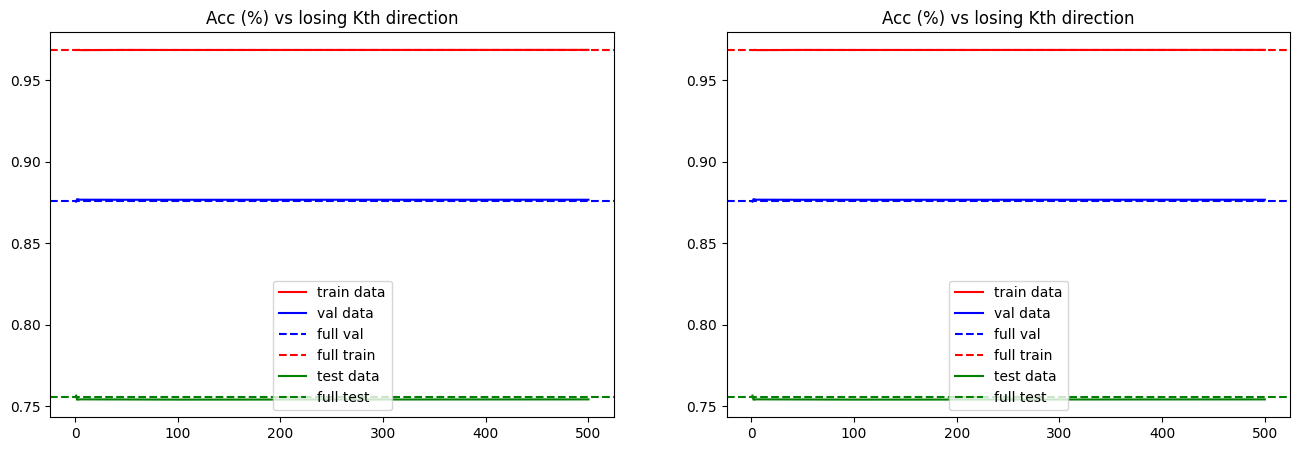

In [196]:
create_results_plot(accs, {k:v.cpu() for k,v in  split_accs.items()},  caption="Acc (%) vs losing Kth direction")

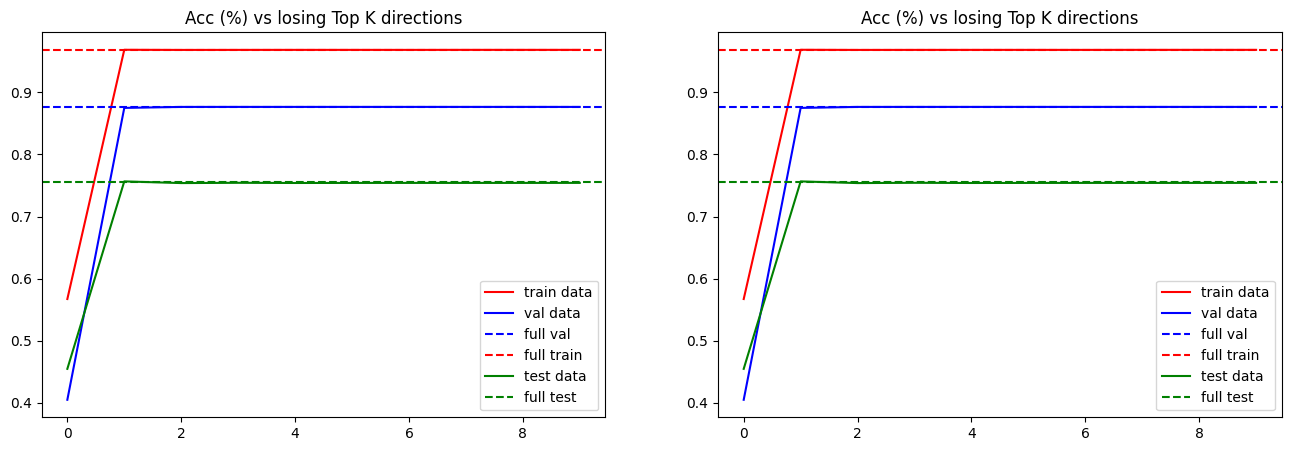

In [129]:
create_results_plot(accs, split_accs,  caption="Acc (%) vs losing Top K directions")

KeyError: 'val'

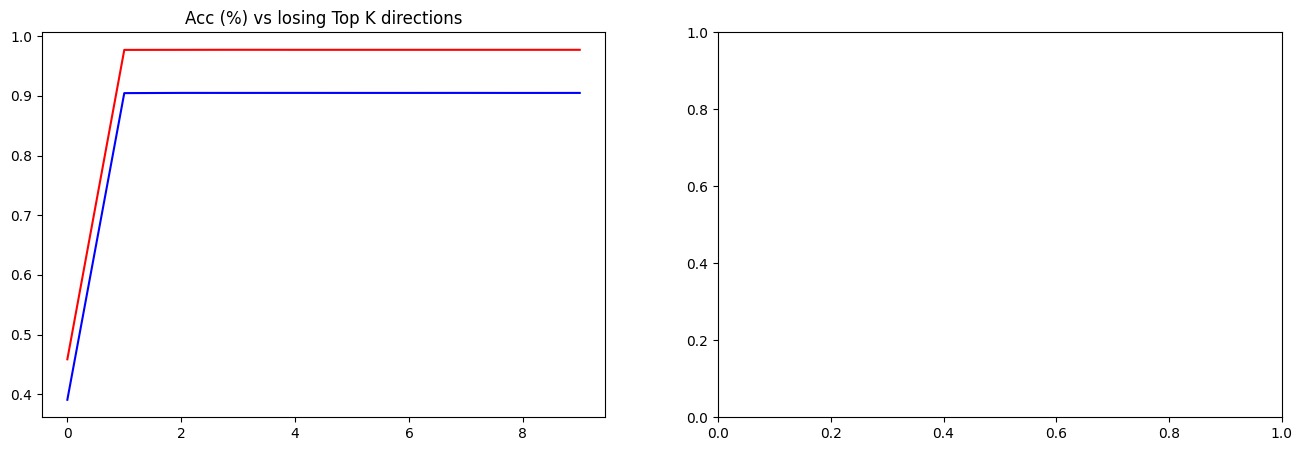

In [134]:
create_results_plot(accs, split_accs,  caption="Acc (%) vs losing Top K directions")

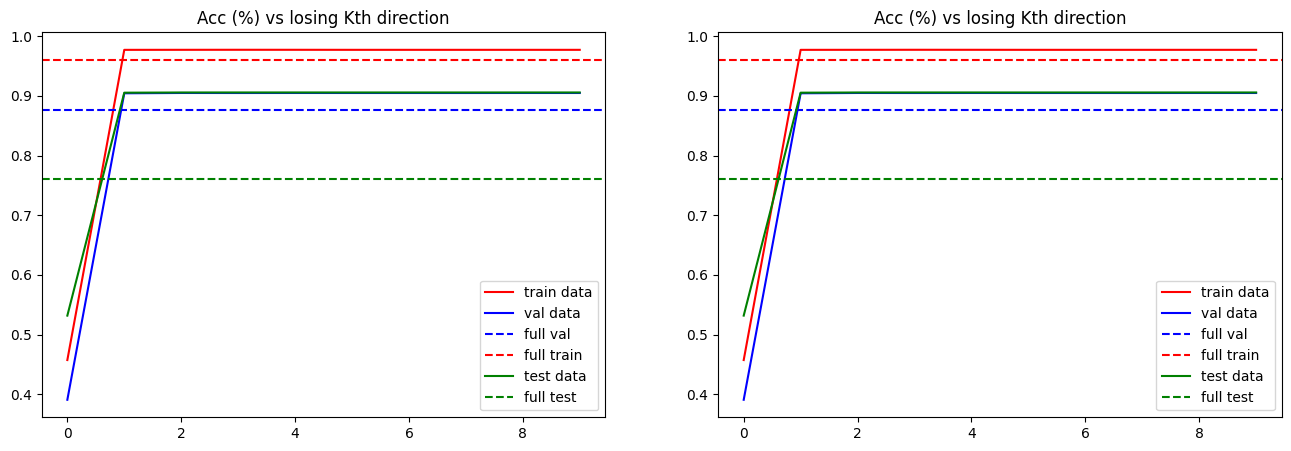

In [152]:
create_results_plot(accs, split_accs,  caption="Acc (%) vs losing Kth direction")

In [151]:
split_accs = {'id_val': 0.96, 'val': 0.8755, 'test': 0.76}

In [162]:
for s in S:
    print(s)

tensor(3298.0903, grad_fn=<UnbindBackward0>)
tensor(1941.7943, grad_fn=<UnbindBackward0>)
tensor(1470.5286, grad_fn=<UnbindBackward0>)
tensor(1288.3173, grad_fn=<UnbindBackward0>)
tensor(1170.4664, grad_fn=<UnbindBackward0>)
tensor(1090.8020, grad_fn=<UnbindBackward0>)
tensor(1031.1235, grad_fn=<UnbindBackward0>)
tensor(863.1502, grad_fn=<UnbindBackward0>)
tensor(822.2694, grad_fn=<UnbindBackward0>)
tensor(795.4197, grad_fn=<UnbindBackward0>)
tensor(774.6128, grad_fn=<UnbindBackward0>)
tensor(749.1772, grad_fn=<UnbindBackward0>)
tensor(741.2015, grad_fn=<UnbindBackward0>)
tensor(703.2478, grad_fn=<UnbindBackward0>)
tensor(689.6099, grad_fn=<UnbindBackward0>)
tensor(654.6181, grad_fn=<UnbindBackward0>)
tensor(627.9109, grad_fn=<UnbindBackward0>)
tensor(620.1641, grad_fn=<UnbindBackward0>)
tensor(606.8447, grad_fn=<UnbindBackward0>)
tensor(576.9796, grad_fn=<UnbindBackward0>)
tensor(559.6009, grad_fn=<UnbindBackward0>)
tensor(528.5947, grad_fn=<UnbindBackward0>)
tensor(517.8444, grad_fn=

In [175]:
split_accs

{'id_val': tensor(0.9685, device='cuda:0'),
 'val': tensor(0.8758, device='cuda:0'),
 'test': tensor(0.7555, device='cuda:0')}

In [197]:
accs

defaultdict(list,
            {'id_val': [tensor(0.9684),
              tensor(0.9683),
              tensor(0.9684),
              tensor(0.9684),
              tensor(0.9683),
              tensor(0.9684),
              tensor(0.9684),
              tensor(0.9684)],
             'val': [tensor(0.8754),
              tensor(0.8769),
              tensor(0.8768),
              tensor(0.8767),
              tensor(0.8766),
              tensor(0.8765),
              tensor(0.8765),
              tensor(0.8766)],
             'test': [tensor(0.7565),
              tensor(0.7539),
              tensor(0.7543),
              tensor(0.7541),
              tensor(0.7542),
              tensor(0.7541),
              tensor(0.7540),
              tensor(0.7542)]})

In [161]:
a=3
b=a
a=2
b

3